In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output, Audio
import dataloader
import madmom
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ipywidgets import interactive
import circularPitchSpace as cps
import matplotlib.gridspec as gridspec
import features
import librosa
import utils
import scipy
%matplotlib inline

dataset = None

plt.rcParams['text.usetex'] = True

def update_dropdown_id_options(*args):
    global dataset
    selected_split = dropdown_split.value
    dataset = dataloader.MIRDataset("beatles", use_deep_chroma=True, align_chroma=False, split_nr=selected_split)
    dropdown_id.options = list(dataset.getTrackList().keys())
    dropdown_id.value = list(dataset.getTrackList().keys())[0]  # Set the default value

def update_selected_track_id(*args):
    selected_track_id = dataset.getTrackList()[dropdown_id.value]
    textbox_track_id.value = selected_track_id
    

# Create the dropdown widgets
dropdown_split = widgets.Dropdown(
    options=[1, 2, 3, 4, 5, 6, 7],
    value = 3,
    description='Split:',
    disabled=False,
)

dropdown_id = widgets.Dropdown(
    description='Track ID:',
    disabled=False,
)

textbox_track_id = widgets.Text(
    description='Selected Track ID:',
    disabled=True,
)
update_dropdown_id_options()
update_selected_track_id()
# Register the event handlers
dropdown_split.observe(update_dropdown_id_options, 'value')
dropdown_id.observe(update_selected_track_id, 'value')

# Display the widgets
display(dropdown_split, dropdown_id, textbox_track_id)


Dropdown(description='Split:', index=2, options=(1, 2, 3, 4, 5, 6, 7), value=3)

Dropdown(description='Track ID:', options=('0101', '0104', '0209', '0306', '0308', '0401', '0408', '0506', '06…

Text(value='01_-_I_Saw_Her_Standing_There', description='Selected Track ID:', disabled=True)

load features for selected audiofile

In [3]:
audiopath,target = dataset[dropdown_id.value]
ref_intervals, ref_labels = target
y,sr = librosa.load(audiopath)
time_vector = np.linspace(0,(y.shape[0]-1)/sr,y.shape[0])
deep_chroma = features.deepChroma(audiopath) # reference model
crp_chroma = features.crpChroma(y)
beat_processor = madmom.features.downbeats.DBNDownBeatTrackingProcessor(2,fps=100)
activation_processor =  madmom.features.downbeats.RNNDownBeatProcessor()
activations = activation_processor(audiopath)
beats = beat_processor(activations)
intervals = features.intervalCategories(crp_chroma)
complexity_features = [ 
                        features.sumChromaDifferences(crp_chroma),
                        features.angularDeviation(crp_chroma),
                        features.flatness(crp_chroma),
                        features.shannonEntropy(crp_chroma),
                        features.negativeSlope(crp_chroma),
                        features.nonSparseness(crp_chroma)
                       ] 
time_vector_crp = np.linspace(0,time_vector[-1],crp_chroma.shape[0])
time_vector_dcp = np.linspace(0,time_vector[-1],deep_chroma.shape[0])


/home/max/.local/lib/python3.10/site-packages/madmom/features/downbeats.py:287: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  best = np.argmax(np.asarray(results)[:, 1])


find out wich key is most suited for chord recognition with the pitch space model and compute cps features

In [4]:
alpha=0.95
threshold=0.7
angle_weight=0.6
pc_energy = cps.getPitchClassEnergyProfile(crp_chroma,threshold=threshold,angle_weight=angle_weight)
pc_energy_filtered = np.zeros_like(pc_energy)
pc_energy_filtered[0,:] = pc_energy[0,:] 
for i in range(1,pc_energy.shape[0]):
    pc_energy_filtered[i,:] = alpha * pc_energy_filtered[i-1,:] + (1-alpha) * pc_energy[i,:]
keys = np.argsort(pc_energy_filtered,axis=1)[:,-3:]

# compute cps features for for the three most likely keys
rho_F  = np.zeros((crp_chroma.shape[0],),dtype=complex)
rho_FR = np.zeros((crp_chroma.shape[0],3),dtype=complex)
rho_TR = np.zeros((crp_chroma.shape[0],3),dtype=complex)

for time_index in range(crp_chroma.shape[0]):
    # compute cps features 
    for i,pitch_class_index in enumerate(keys[time_index]):
        n_k = cps.pitch_classes[pitch_class_index].num_accidentals
        for pitch_class,chroma_bin in zip(cps.pitch_classes,crp_chroma[time_index,:]):
            n_f = cps.sym3(49*pitch_class.chromatic_index,84,7*n_k)
            if i == 0:
                # calculate vector entries for circle of fifth
                rho_F[time_index] += chroma_bin * np.exp(-1j*2*np.pi*(n_f/84))
            # check if pitch is part of the key
            if cps.checkIndex(n_f,n_k):
                # fifth related circle
                n_fr = cps.sym(n_f-7*n_k, 48)
                rho_FR[time_index,i] += chroma_bin*np.exp(-1j*2*np.pi*(n_fr/48))
                # third related circle  
                n_tr = cps.sym(n_f-7*n_k-12,24)
                rho_TR[time_index,i] += chroma_bin*np.exp(-1j*2*np.pi*(n_tr/24))   


compute angular difference between chord prototypes to estimate the Chord label

In [12]:

# calculate angles of triad prototypes for chord estimation
templates, labels = cps.createChordTemplates("triads",root_only=False)
phi_FR = np.zeros((7,))
phi_TR = np.zeros((7,))
x_F,x_FR,x_TR,x_DR = cps.transformChroma(templates[0,:,:])
x_FR = x_FR[:,0] # one key is sufficient for computation
x_TR = x_TR[:,0]
d_FR = np.zeros_like(x_FR,dtype=float)
d_TR = np.zeros_like(x_TR,dtype=float)
unfiltered_labels = [] # estimated chord lables

for time_index in range(crp_chroma.shape[0]):
    # compute angle difference
    chord_labels = []
    for i,pitch_class_index in enumerate(keys[time_index]):
        for template in range(7):
            d_FR[template] = cps.calculateDistance(rho_FR[time_index,i],x_FR[template])
            d_TR[template] = cps.calculateDistance(rho_TR[time_index,i],x_TR[template])
        d = np.argmin(d_FR+d_TR)
        chord_labels.append(labels[pitch_class_index][d])
    unfiltered_labels.append(chord_labels[0]) # only keep the first label!

# create intervals 
est_intervals = []
est_labels = []
t_start = time_vector_crp[0]
current_label = "N"
for i,label in enumerate(unfiltered_labels[:-1]):
    if label == current_label:
        continue
    est_labels.append(current_label)
    est_intervals.append([t_start,time_vector_crp[i]])
    # initialize new interval
    current_label = label
    t_start = time_vector_crp[i]
est_intervals = np.array(est_intervals)
print(est_labels,est_intervals)

['N', 'D#:maj', 'F:maj', 'C:min', 'C:maj', 'E:maj', 'C:maj', 'A:min', 'C:maj', 'A:min', 'C:maj', 'A:min', 'C:maj', 'G:maj', 'C:min', 'G:maj', 'G:min', 'A:dim', 'F:maj', 'A:min', 'A:maj', 'A:min', 'C:maj', 'A:min', 'F:min', 'G#:maj', 'F:min', 'D:min', 'F:maj', 'D:min', 'F:maj', 'C:maj', 'C:min', 'C:maj', 'C:min', 'C:maj', 'G:maj', 'G:min', 'G:maj', 'F:maj', 'D:maj', 'A:maj', 'F:maj', 'F#:dim', 'F:maj', 'F:min', 'F:maj', 'C:maj', 'A:maj', 'D:min', 'D:maj', 'F:maj', 'C:maj', 'C:min', 'G#:maj', 'C:min', 'A:min', 'C:maj', 'C:min', 'C:maj', 'A:min', 'C:maj', 'A:min', 'F#:dim', 'A:min', 'C:min', 'F:min', 'G#:maj', 'C:maj', 'G#:maj', 'C:min', 'G#:maj', 'C:min', 'G:dim', 'G:maj', 'G:min', 'G:maj', 'G:min', 'C:min', 'C:maj', 'G:maj', 'A#:maj', 'G:min', 'G:maj', 'E:min', 'A:min', 'A:maj', 'D:maj', 'D:min', 'A:min', 'A:maj', 'A:min', 'D:min', 'A:min', 'A:maj', 'C:maj', 'G:maj', 'D:min', 'A:min', 'F#:dim', 'A:min', 'F:min', 'D:min', 'G:maj', 'C:maj', 'C:min', 'F:maj', 'C:min', 'C:maj', 'C:min', 'C:

Plot prediction results

Text(0.5, 0, 'Time in s')

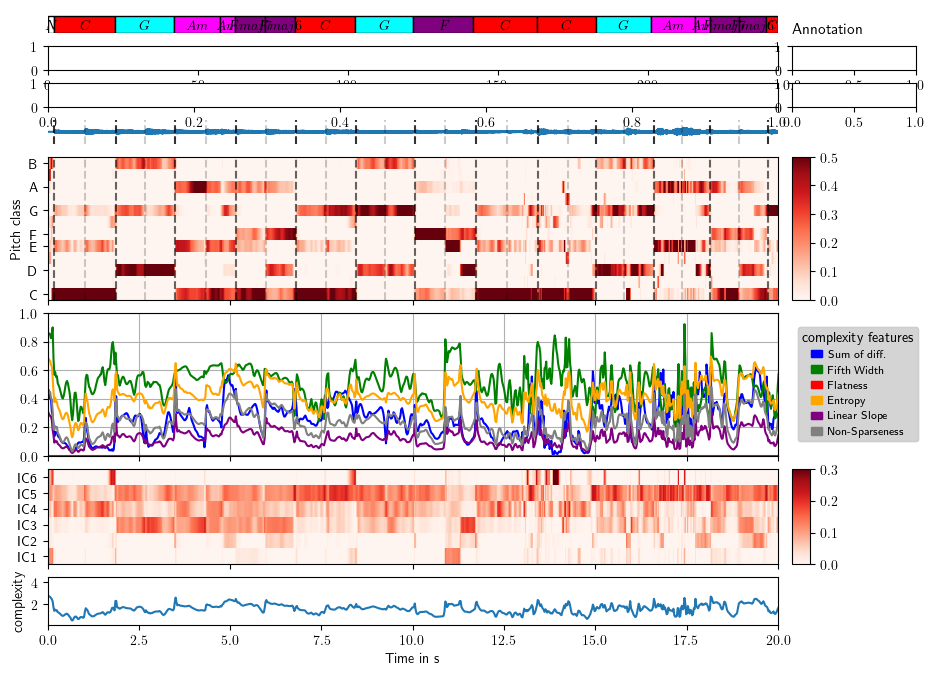

In [8]:
start = 0
stop = 20

# define gridspec and axes
fig = plt.figure(figsize=(14*0.8, 10*0.8))
gs = gridspec.GridSpec(8, 3,width_ratios=(40,1,5),height_ratios=(1,1,1,1,6,6,4,2), hspace=0.2,wspace=0.05)
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1:3])
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1:3])
ax20 = fig.add_subplot(gs[2,0])
ax21 = fig.add_subplot(gs[2,1:3])
ax30 = fig.add_subplot(gs[3,0])

ax40 = fig.add_subplot(gs[4,0])
ax41 = fig.add_subplot(gs[4,1])
ax50 = fig.add_subplot(gs[5,0])
ax51 = fig.add_subplot(gs[5,1:3])
ax60 = fig.add_subplot(gs[6,0])
ax61 = fig.add_subplot(gs[6,1])
ax70 = fig.add_subplot(gs[7,0])

utils.plotChordAnnotations(ax00,target,time_interval=(start,stop))
ax10.set_xlim(time_vector[0],time_vector[-1])
ax01.text(0,0,"Annotation",fontsize=11)
ax01.set_axis_off()

# utils.plotChordAnnotations(ax10,estimation_cps,time_interval=(start,stop))
# ax10.set_xlim(time_vector[0],time_vector[-1])
# ax11.text(0,0,"CPS",fontsize=11)
# ax11.set_axis_off()

# utils.plotChordAnnotations(ax20,estimation_templates,time_interval=(start,stop))
# ax20.set_xlim(time_vector[0],time_vector[-1])
# ax21.text(0,0,"Templates",fontsize=11)
# ax21.set_axis_off()

utils.plotAudioWaveform(ax30,y,time_interval=(start,time_vector[-1]),beats=beats,downbeats=True)
ax30.set_xlim(start,stop)
ax30.set_axis_off()

img = utils.plotChromagram(ax40, time_vector_crp, crp_chroma,beats=beats,downbeats=True)
ax40.set_xlabel("")
ax40.set_xlim(start,stop)
ax40.set_xticklabels([])
fig.colorbar(img,cax=ax41,cmap="Reds")

# features
colors = ["blue", "green", "red", "orange", "purple", "grey", "black"]
for i,feature in enumerate(complexity_features):
    ax50.plot(time_vector_crp, feature,color=colors[i])
ax50.set_xlim(start,stop)
ax50.set_xticklabels([])
ax50.set_ylim(0,1)
ax50.grid(True)
#create legend
labels = ['Sum of diff.',"Fifth Width","Flatness","Entropy","Linear Slope","Non-Sparseness"]
legend_handles = [patches.Patch(color=color) for color in colors]
legend = ax51.legend(legend_handles, labels, loc='center left', bbox_to_anchor=(0, 0.5), title='complexity features', handlelength=1, handletextpad=0.5, fontsize=8, title_fontsize=10, facecolor='lightgray', framealpha=0.8)
ax51.add_artist(legend)
ax51.set_axis_off()

img = librosa.display.specshow(intervals.T,x_coords=time_vector_crp.T,x_axis='time', cmap="Reds", ax=ax60, vmin=0, vmax=0.3)
ax60.set_yticks(np.arange(6))
ax60.set_yticklabels(["IC1","IC2","IC3","IC4","IC5","IC6"]);
ax60.set_xlim(start,stop)
ax60.set_xticklabels([])
fig.colorbar(img,cax=ax61,cmap="Reds")

ax70.plot(time_vector_crp,np.sum(np.array(complexity_features),axis=0))
ax70.set_ylabel("complexity")
ax70.set_xlim(start,stop);
ax70.set_xlabel("Time in s")